# **Исследование данных музыкального сервиса - сравнение музыкальных предпочтений пользователей двух городов**
---

**Цель исследования** — проверка трёх гипотез:
1. Активность пользователей зависит от дня недели. Причём в в разных городах это проявляется по-разному.
2. В понедельник в одном городе преобладают одни жанры, а в другом — другие. Так же и в пятницу преобладают разные жанры — в зависимости от города.
3. В разных городах предпочитают разные жанры музыки.

**Ход исследования**

Данные о поведении пользователей хранятся взяты с kaggle. О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных. 

Необходимо проверить данные на ошибки и оценить их влияние на исследование. Затем, на этапе предобработки следует поискать возможность исправить самые критичные ошибки данных.
 
Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Проверка гипотез.

---

## Обзор данных

Составим первое представление о данных.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

Прочитаем файлы, соедим, отберём нужные столбцы и сохраним его в файл `df_songs.csv`:

In [4]:
song_df = pd.read_csv('songs.csv')
song_ex_df = pd.read_csv('song_extra_info.csv')
user_df = pd.read_csv('members.csv')
train_df = pd.read_csv('train.csv')
s_se = pd.merge(train_df, song_df, on='song_id', how='left')
s_se_t = pd.merge(s_se, song_ex_df, on='song_id', how='left')
songs = pd.merge(s_se_t, user_df, on='msno', how='left')
songs = songs.iloc[:, [0, 12, 8, 7, 14, 6, 18]] # Оставляем только нужные столбцы
del song_df, song_ex_df, user_df, train_df, s_se, s_se_t

Для анализа возьмем 8й и 9й город.

In [5]:
songs.city.value_counts()
songs = songs.loc[(songs.city == 8) | (songs.city == 9)]
songs = songs.reset_index(drop=True)
songs.to_csv('df_songs.csv',)

In [6]:
songs.head()

,msno,name,artist_name,genre_ids,city,song_length,registration_init_time
0,uQQHTQJ1nVEkBfbXe0f1/J9ML5eQhsQiocCV5TvvCRI=,雨天 (雨天),孫燕姿 (Yanzi Sun),465,9,241975.0,20130912
1,uQQHTQJ1nVEkBfbXe0f1/J9ML5eQhsQiocCV5TvvCRI=,EGO-HOLIC戀我癖 (EGO-HOLIC),陳星翰 (Starr Chen),458,9,189846.0,20130912
2,uQQHTQJ1nVEkBfbXe0f1/J9ML5eQhsQiocCV5TvvCRI=,愛死你,莫文蔚 (Karen Mok),465,9,247911.0,20130912
3,uQQHTQJ1nVEkBfbXe0f1/J9ML5eQhsQiocCV5TvvCRI=,麥來亂,五月天 (Mayday),465,9,257671.0,20130912
4,Ix1RlLsCGktMc8Q5oogErdJbfKL+HYj116+bYZ4qzMc=,愛久見人心,梁靜茹 (Fish Leong),458,8,296542.0,20130722


In [7]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180971 entries, 0 to 180970
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    180971 non-null  object 
 1   name                    180936 non-null  object 
 2   artist_name             180969 non-null  object 
 3   genre_ids               178048 non-null  object 
 4   city                    180971 non-null  int64  
 5   song_length             180969 non-null  float64
 6   registration_init_time  180971 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 9.7+ MB


Итак, в таблице у нас получилось семь столбцов.

Согласно документации к данным:
* `msno` — идентификатор пользователя;
* `name` — название трека;  
* `artist_name` — имя исполнителя;
* `genre_ids` — id жанра;
* `city` — город пользователя;
* `song_length` — длительность песни;
* `registration_init_time` — дата первого прослушивания;


Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

#### **Выводы**

В каждой строке таблицы — данные о прослушанном треке. Часть колонок описывает саму композицию: название, исполнителя и жанр. Остальные данные рассказывают о пользователе: из какого он города, когда он слушал музыку.

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются пропуски в данных.

Пропуски в данных наблюдаются только в колонках, описывающих саму композицию, что может свидетельствовать об ошибках при извлечении данных о композициях, либо о том, что в системе поля Track, artist и genre_ids являются необязательными и теоретически возможна ситуация, когда все три поля будут пропущены одновременно. Целесообразно проконсультироваться с разработчиками.

С точки зрения постановки задачи наиболее важным является столбец genre_ids.

Чтобы двигаться дальше, устраним проблемы в данных.

## **Предобработка данных**
Исправим стиль в заголовках столбцов, исключим пропуски.

### Стиль заголовков
Выведем на экран названия столбцов:

In [8]:
songs.columns

Index(['msno', 'name', 'artist_name', 'genre_ids', 'city', 'song_length',
       'registration_init_time'],
      dtype='object')

In [9]:
# Изменим названия на более понятные.
songs = songs.rename(
    columns={
        'msno' : 'user_id',
        'name' : 'track',
        'artist_name' : 'artist',
        'genre_ids' : 'genre_id',
        'registration_init_time' : 'date'
    }
)

In [10]:
# проверка результатов - перечень названий столбцов
songs.columns

Index(['user_id', 'track', 'artist', 'genre_id', 'city', 'song_length',
       'date'],
      dtype='object')

### Работа с пропущенными значениями
Сначала посчитаем, сколько в таблице пропущенных значений:

In [11]:
# подсчёт пропусков
songs.isna().sum()

user_id           0
track            35
artist            2
genre_id       2923
city              0
song_length       2
date              0
dtype: int64

In [12]:
columns_to_replace = ['track', 'artist', 'genre_id', 'song_length']

for col in columns_to_replace:
    songs[col] = songs[col].fillna('unknown')

### Дубликаты
Посчитаем явные дубликаты в таблице:

In [13]:
songs.duplicated().sum()

626

Удалим явные дубликаты:

In [14]:
# удаление явных дубликатов
songs = songs.drop_duplicates()

Ещё раз посчитаем явные дубликаты, чтобы убедиться, что полностью от них избавились:

In [15]:
# проверка на отсутствие дубликатов
songs.duplicated().sum()

0

Теперь избавимся от неявных дубликатов в колонке `genre_ids`. Например, в данных id могут быть записаны парами. Такие ошибки тоже повлияют на результат исследования.

Выведем на экран список уникальных названий жанров, отсортированный в алфавитном порядке. Для этого:
* извлеките нужный столбец датафрейма
* примените к нему метод сортировки
* для отсортированного столбца вызовите метод, который вернёт уникальные значения из столбца

In [16]:
# Просмотр уникальных названий жанров
songs['genre_id'].sort_values().unique()

array(['1011', '1026', '1040', '1040|1155', '1047', '1054', '1082', '109',
       '1096', '109|118', '109|139', '109|465', '109|94', '1117', '1138',
       '1145', '1152', '1152|2022', '1152|242|947', '1152|465',
       '1152|465|1180', '1152|726', '1152|786', '1152|829', '1152|921',
       '1152|940', '1152|947', '1155', '118', '1180', '1180|2022',
       '1180|465', '118|1259', '1208', '1259', '1259|359', '1266', '1273',
       '1280', '1280|2093', '1287', '139', '139|1259', '139|1259|125|109',
       '139|125|109', '139|444|109', '1568', '1572|275', '1598', '1605',
       '1609', '1609|1259', '1609|139', '1609|1969|2100', '1609|2058',
       '1609|2086|374', '1609|2107', '1609|2122', '1609|2122|2022',
       '1609|359', '1609|458', '1609|465', '1609|786', '1609|947|2022',
       '1616', '1616|1609', '1616|2058', '1616|2072', '1616|2116', '1633',
       '1633|310', '1944|310', '1955', '1969', '1969|1609|2100',
       '1988|1981|430', '2022', '2022|1259', '2022|1955', '2022|359',
    

В списке выявлены следующие неявные дубликаты:
Парные id

Чтобы очистить от них таблицу, напишем функцию `replace_wrong_genres()` с одним параметром: 
* `gen` — список id

Функция исправляет колонку `genre_id` в таблице `songs`: заменяет каждое значение c символом `|` на первый id.

In [17]:
# функция для замены неявных дубликатов
def replace_wrong_genres(gen):
    nw_gen = []
    for i in gen:
        index = i.find('|')
        if index != -1:
            i = i[:index]
        nw_gen.append(i)
    return nw_gen

Устраним неявные дубликаты

In [18]:
songs['genre_id'] = replace_wrong_genres(songs['genre_id'])

Проверим корректность устранения неявных дубликатов. Выведем отсортированный список уникальных значений столбца `genre`:

In [19]:
# Проверка на неявные дубликаты
songs['genre_id'].sort_values().unique()

array(['1011', '1026', '1040', '1047', '1054', '1082', '109', '1096',
       '1117', '1138', '1145', '1152', '1155', '118', '1180', '1208',
       '1259', '1266', '1273', '1280', '1287', '139', '1568', '1572',
       '1598', '1605', '1609', '1616', '1633', '1944', '1955', '1969',
       '1988', '2022', '2029', '2032', '2072', '2079', '2086', '2093',
       '2107', '2109', '2116', '212', '2122', '2130', '2144', '2157',
       '2176', '2189', '2194', '2213', '2248', '242', '252', '275', '352',
       '359', '374', '381', '388', '402', '409', '423', '430', '437',
       '444', '451', '458', '465', '474', '481', '509', '516', '531',
       '545', '656', '691', '698', '712', '719', '726', '786', '798',
       '822', '829', '864', '873', '880', '893', '900', '921', '94',
       '940', '947', '95', '958', '965', '972', '979', '986', 'unknown'],
      dtype=object)

### Заменим данные в столбце `date` с полной даты на день недели.

Напишим функцию, которая будет получать дату в формате ГГГГММДД и выдавать день недели. Для этого используем модуль datetime.

In [20]:
# Создадим словарь
week_day = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

def to_week_day(lst_date):
    lst_week_day = []
    for sdate in lst_date:
        week_id = datetime.datetime(sdate//10000, sdate%10000//100, sdate%100)
        lst_week_day.append(week_day[week_id.weekday()])  
    return lst_week_day

In [21]:
songs['date'] = to_week_day(songs['date'])
songs['date']

0             Четверг
1             Четверг
2             Четверг
3             Четверг
4         Понедельник
             ...     
180966    Воскресенье
180967    Воскресенье
180968    Воскресенье
180969    Воскресенье
180970    Воскресенье
Name: date, Length: 180345, dtype: object

**Выводы**

Предобработка обнаружила три проблемы в данных:

- нарушения в стиле заголовков,
- пропущенные значения,
- дубликаты — явные и неявные.

Мы исправили заголовки, чтобы упростить работу с таблицей. Без дубликатов исследование станет более точным.

Пропущенные значения мы заменили на `'unknown'`. Ещё предстоит увидеть, не повредят ли исследованию пропуски в колонке `genre_id`.

Теперь можно перейти к проверке гипотез. 

---

## Проверка гипотез

### Сравним распределение активности по по дням недели для каждого города.

Согласно первой гипотезе, пользователи из разных городов по разному прослушивают музыку.

Город 8:

In [ ]:
event_week_8 = songs[songs['city']==8].groupby('date')['city'].count()
event_week_8

date
Воскресенье    19614
Вторник         9364
Понедельник    11809
Пятница        14703
Среда           6383
Суббота        10420
Четверг        13148
Name: city, dtype: int64

Text(0.5, 1.0, 'Количество прослушиваний по дням недели')

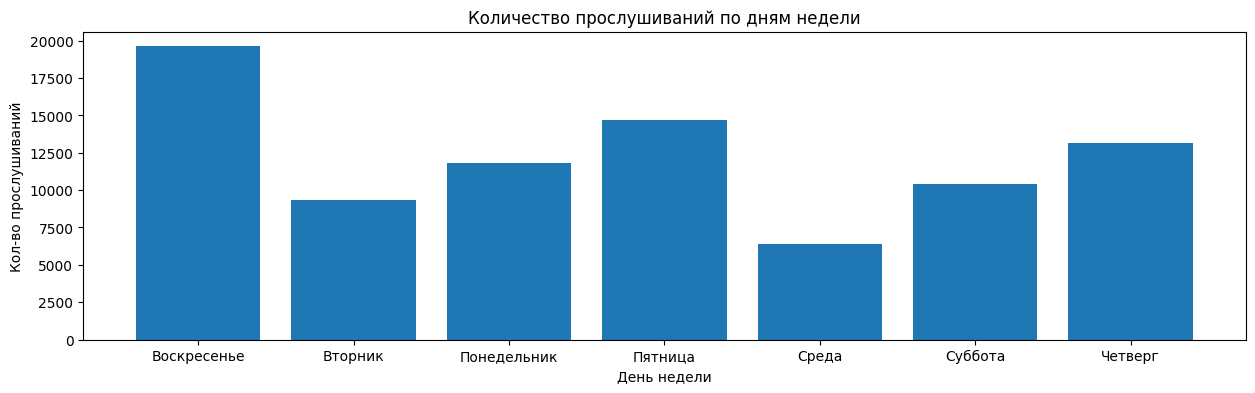

In [ ]:
plt.figure(figsize=(15,4))
plt.bar(range(len(event_week_8)), event_week_8)
plt.xlabel('День недели')
plt.xticks(range(len(event_week_8)), event_week_8.index)
plt.ylabel('Кол-во прослушиваний')
plt.title('Количество прослушиваний по дням недели')

*На графике видно, что больше всего прослушиваний приходится на воскресенье и меньше всего – на среду.*

Город 9:

In [ ]:
event_week_9 = songs[songs['city']==9].groupby('date')['city'].count()
event_week_9

date
Воскресенье    12461
Вторник        11647
Понедельник    12302
Пятница        13787
Среда          14029
Суббота        17083
Четверг        13595
Name: city, dtype: int64

Text(0.5, 1.0, 'Количество прослушиваний по дням недели')

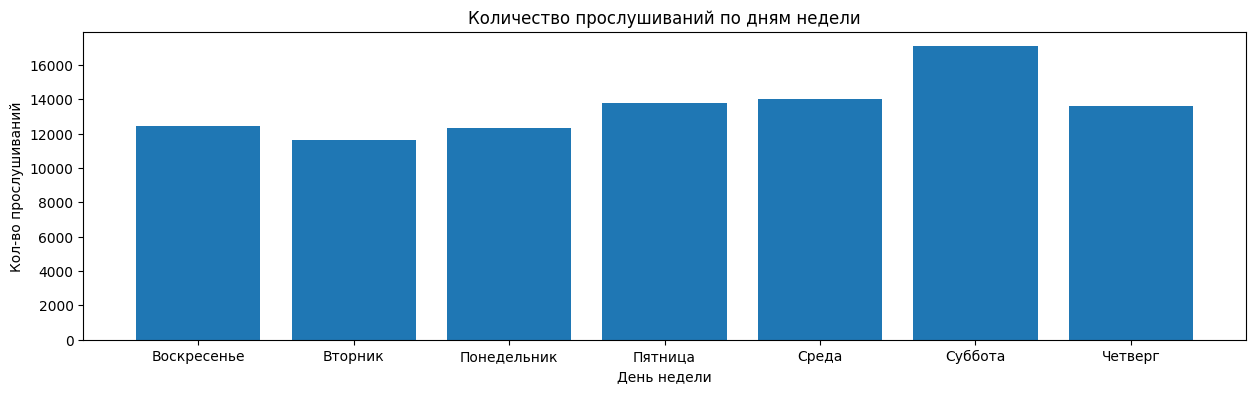

In [ ]:
plt.figure(figsize=(15,4))
plt.bar(range(len(event_week_9)), event_week_9)
plt.xlabel('День недели')
plt.xticks(range(len(event_week_9)), event_week_9.index)
plt.ylabel('Кол-во прослушиваний')
plt.title('Количество прослушиваний по дням недели')

*В субботу наибольшее количество прослушиваний, а во вторник наименьшее.*

Таблица для сравнения двух городов

In [ ]:
pd.DataFrame([[8, *event_week_8],
             [9, *event_week_9]], columns=['city', *event_week_8.index])

,city,Воскресенье,Вторник,Понедельник,Пятница,Среда,Суббота,Четверг
0,8,19614,9364,11809,14703,6383,10420,13148
1,9,12461,11647,12302,13787,14029,17083,13595


**Вывод**

Данные показывают разницу поведения пользователей:

- В городе 8 пик прослушиваний приходится на воскресенье, а в среду заметен спад.
- В гророде 9, больше слушают музыку по субботам и менше по вторникам. 

Значит, данные говорят в пользу первой гипотезы.

### Музыка в начале и в конце недели

Вторая гипотеза утверждает, что в начале и в конце недели пользователи разных городов слушают разные жанры музыки.

Посмотрим на самые популярные жанры понедельника и пятницы для 8го города:

In [ ]:
city_8 = songs[(songs['city'] == 8)] #Данные города 8

genre_mo_8 = city_8[city_8['date'] == 'Понедельник'].groupby('genre_id')['user_id'].count().sort_values(ascending=False)
genre_fr_8 = city_8[city_8['date'] == 'Пятница'].groupby('genre_id')['user_id'].count().sort_values(ascending=False)

print(f'Самый популярный жанр понедельника – {genre_mo_8.index[0]} \nСамый популярный жанр пятницы – {genre_fr_8.index[0]}')

Самый популярный жанр понедельника – 465 
Самый популярный жанр пятницы – 465


Оказывается пользователи любят слушать один и тот же жанр как в понедельник так и в пятницу.

Посмотрим на популярные жанры города 9:

In [ ]:
city_9 = songs[(songs['city'] == 9)] #Данные города 9

genre_mo_9 = city_9[city_9['date'] == 'Понедельник'].groupby('genre_id')['user_id'].count().sort_values(ascending=False)
genre_fr_9 = city_9[city_9['date'] == 'Пятница'].groupby('genre_id')['user_id'].count().sort_values(ascending=False)

print(f'Самый популярный жанр понедельника – {genre_mo_9.index[0]} \nСамый популярный жанр пятницы – {genre_fr_9.index[0]}')

Самый популярный жанр понедельника – 465 
Самый популярный жанр пятницы – 465


В городе 9 тоже в основном любят один жанр, не зависимо от дня недели.

### Посмотрим топ-5 жанров для понедельника и пятницы:

Город 8

Text(0.5, 0, 'Id жанра')

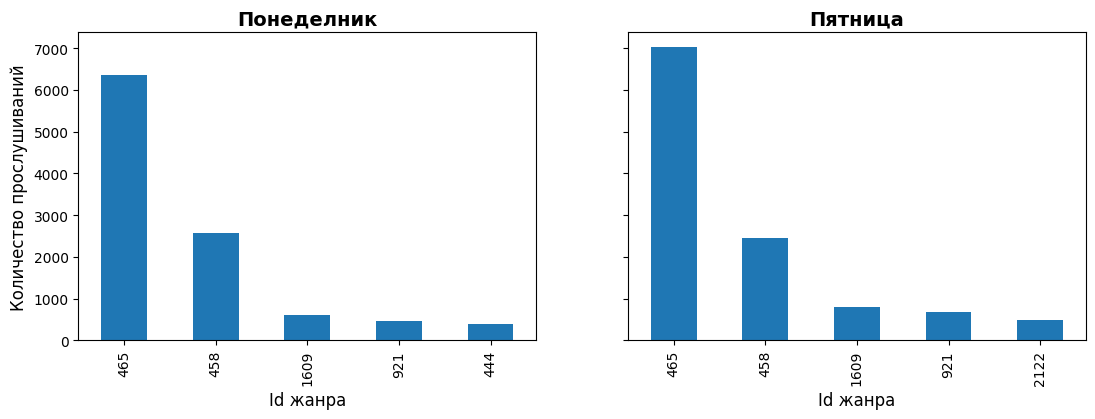

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,4))

genre_mo_8.head(5).plot.bar(ax=ax1)
ax1.set_ylabel('Количество прослушиваний',size=12)
ax1.set_title('Понеделник', fontweight="bold",size=14)
ax1.set_xlabel('Id жанра',size=12)

genre_fr_8.head(5).plot.bar(ax=ax2)
ax2.set_title('Пятница', fontweight="bold",size=14)
ax2.set_xlabel('Id жанра',size=12)

*Первые 4е позиции в топе идентичны.*


Город 9

Text(0.5, 0, 'Id жанра')

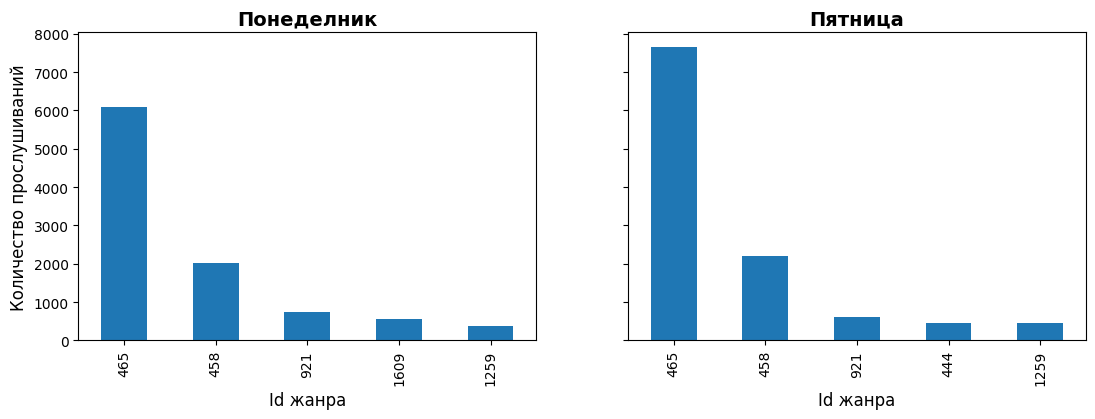

In [ ]:
fig, (ax3, ax4) = plt.subplots(1, 2, sharey=True, figsize=(13,4))
genre_mo_9.head(5).plot.bar(ax=ax3)
ax3.set_ylabel('Количество прослушиваний',size=12)
ax3.set_xlabel('Id жанра',size=12)
ax3.set_title('Понеделник', fontweight="bold",size=14)

genre_fr_9.head(5).plot.bar(ax=ax4)
ax4.set_title('Пятница', fontweight="bold",size=14)
ax4.set_xlabel('Id жанра',size=12)

*Тут видно, что первые 3 позиции в топе одинаковы для понедельника и пятницы.*

**Вывод**

Если сравнить топ-5 жанров в понедельник, можно сделать такие выводы:

* В обоих городах слушают похожую музыку. Отличие можно заметить на 5м месте, но скорее всего если брать больше данных, то жанры будут стоять на почти аналогичных местах.

Пятница слегка меняет эту картину.

Таким образом, вторая гипотеза не подтвердилась:
* Пользователи слушают похожую музыку в начале недели и в конце.
* Разница между 8м и 9м городами не слишком выражена. В основном пользователи слушают музыку с идентификатором жанра 465 и 458.

### Жанровые предпочтения

Третья гипотеза утверждает, что в разных городах пользователи предпочитают разную музыку.

Посмотрим на топ-10 жанров для каждого из городов.

Город 8

In [ ]:
genre_city_8 = city_8.groupby('genre_id')['user_id'].count().sort_values(ascending=False)
genre_city_8.head(10)

genre_id
465        44350
458        15506
1609        4672
921         4065
444         2802
1259        2109
2022        1701
unknown     1375
359         1014
786          790
Name: user_id, dtype: int64

Город 9

In [ ]:
genre_city_9 = city_9.groupby('genre_id')['user_id'].count().sort_values(ascending=False)
genre_city_9.head(10)

genre_id
465        49510
458        16560
921         4947
1609        3892
444         3768
1259        2604
2022        2174
unknown     1545
139         1429
359         1399
Name: user_id, dtype: int64

**Вывод**

Гипотеза не подтвердилась, в разных городах пользователи любят одинаковые жанры музыки.

---

## Итоги

Проверили три гипотезы и установили:

1. День недели по-разному влияет на активность пользователей в городе 8 и городе 9. 

Первая гипотеза полностью подтвердилась.

2. Музыкальные предпочтения не меняются в течение недели. Но небольшие различия всё же заметны.

Таким образом, вторая гипотеза не подтвердилась. Этот результат мог оказаться иным, если бы не пропуски в данных.

3. Вкусы пользователей города 8 и города 9 практически одинаковы.

Третья гипотеза не подтвердилась. Различия видны только с 9 места в топе жанров.